# Use huggingface BERT and XLNet transformers on Tensorflow to carry out text classification

## This notebook is laid out as follows:

### **1)Loading and PreProcessing**

### **2)Text Classification Using BERT**

### **3)Text Classifcation Using XLNet**

### Importing Dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD


In [4]:
train = pd.read_csv('../input/yelp-review-polarity/yelp_review_polarity_csv/train.csv')
test = pd.read_csv('../input/yelp-review-polarity/yelp_review_polarity_csv/test.csv')

In [5]:
train.columns = ['class','text']
test.columns = ['class','text']
train.head()

,class,text
0,2,Been going to Dr. Goldberg for over 10 years. ...
1,1,I don't know what Dr. Goldberg was like before...
2,1,I'm writing this review to give you a heads up...
3,2,All the food is great here. But the best thing...
4,1,Wing sauce is like water. Pretty much a lot of...


### Converting target values to (0,1)

In [6]:
for i in range(0,len(train)):
    if train['class'][i] == 2:
        train['class'][i] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
for i in range(0,len(test)):
    if test['class'][i] == 2:
        test['class'][i] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
train.head()

,class,text
0,0,Been going to Dr. Goldberg for over 10 years. ...
1,1,I don't know what Dr. Goldberg was like before...
2,1,I'm writing this review to give you a heads up...
3,0,All the food is great here. But the best thing...
4,1,Wing sauce is like water. Pretty much a lot of...


## Text Classifcation Using BERT

In [9]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

### Encoding

In [10]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
        
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [11]:
train_input_ids,train_attention_masks = bert_encode(train[:50000],60)
test_input_ids,test_attention_masks = bert_encode(test[:20000],60)

BERT uses 2 inputs:

1) input_ids : List of token ids to be fed to the model

2) attention_masks: List of indices specifying which tokens should be attended to by the model.

### Creating Model

In [12]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

In [14]:
model = create_model(bert_model)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 60, 768), (N 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model[0][1]   

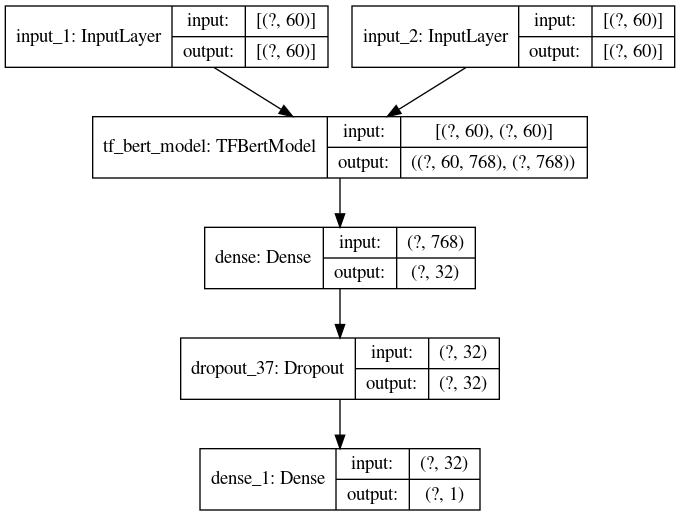

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', expand_nested=True, show_shapes=True)


In [16]:
dummy = train[:50000]
targets = dummy['class'].values

dummy2 = test[:20000]
targets_y = dummy2['class'].values

In [17]:
history = model.fit([train_input_ids,train_attention_masks],targets,validation_data=([test_input_ids,test_attention_masks],targets_y), epochs=4,batch_size=64)

Epoch 1/4
782/782 [==============================] - 395s 505ms/step - loss: 0.3316 - accuracy: 0.8540 - val_loss: 0.2650 - val_accuracy: 0.8843
Epoch 2/4
782/782 [==============================] - 391s 500ms/step - loss: 0.2325 - accuracy: 0.9040 - val_loss: 0.2467 - val_accuracy: 0.8959
Epoch 3/4
782/782 [==============================] - 391s 500ms/step - loss: 0.1887 - accuracy: 0.9232 - val_loss: 0.2561 - val_accuracy: 0.8981
Epoch 4/4
782/782 [==============================] - 391s 500ms/step - loss: 0.1527 - accuracy: 0.9409 - val_loss: 0.2766 - val_accuracy: 0.9005


### Visualizing BERT Performance

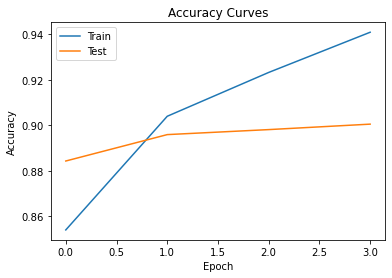

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

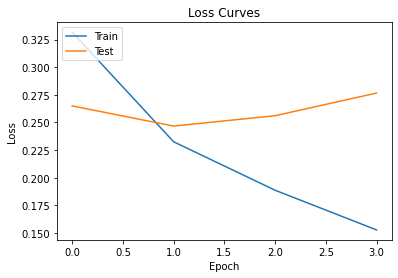

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Text Classification XLNET

In [20]:
from transformers import TFXLNetModel, XLNetTokenizer
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

### Creating Model

In [21]:
def create_model_xlnet(xlnet_model):
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    
    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet(word_inputs)[0]

    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
     
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [22]:
xlnet = create_model_xlnet(xlnet_model)
xlnet.summary()



Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_inputs (InputLayer)     [(None, 120)]             0         
_________________________________________________________________
tfxl_net_model (TFXLNetModel ((None, 120, 768),)       116718336 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1, 768)]          0         
_________________________________________________________________
tf_op_layer_Squeeze (TensorF [(None, 768)]             0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 768)               0         
_________________________________________________________________
outputs (Dense)              (None, 1)                 769       
Total params: 116,719,105
Trainable params: 116,719,105
Non-trainable params: 0
_______________________________________

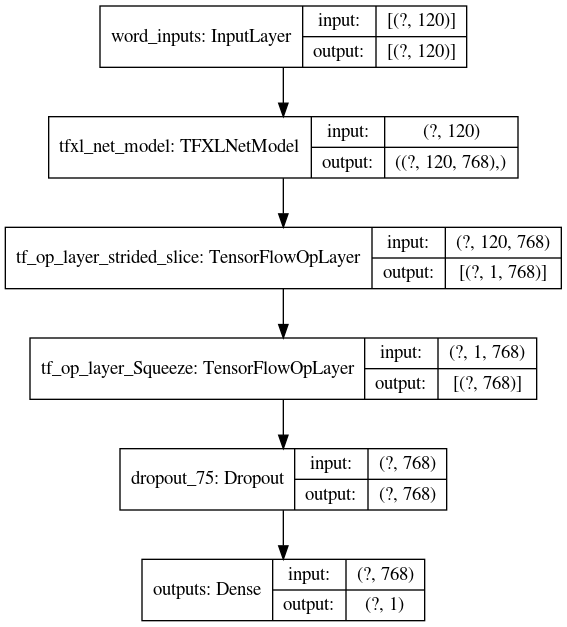

In [23]:
plot_model(xlnet, to_file='model_xl.png', expand_nested=True, show_shapes=True)


In [24]:
history_xl = xlnet.fit(train_input_ids,targets,validation_data=(test_input_ids,targets_y), epochs=4,batch_size=64)

Epoch 1/4
782/782 [==============================] - 472s 604ms/step - loss: 0.6328 - accuracy: 0.6416 - val_loss: 0.4596 - val_accuracy: 0.7781
Epoch 2/4
782/782 [==============================] - 470s 601ms/step - loss: 0.4212 - accuracy: 0.8026 - val_loss: 0.3941 - val_accuracy: 0.8155
Epoch 3/4
782/782 [==============================] - 470s 601ms/step - loss: 0.3406 - accuracy: 0.8469 - val_loss: 0.3619 - val_accuracy: 0.8393
Epoch 4/4
782/782 [==============================] - 470s 601ms/step - loss: 0.2841 - accuracy: 0.8770 - val_loss: 0.3739 - val_accuracy: 0.8472


### Visualizing XLNet performance

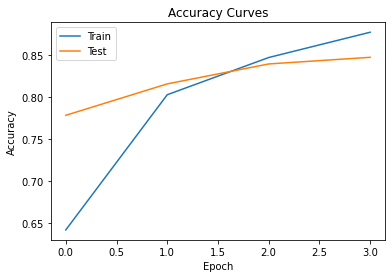

In [25]:
plt.plot(history_xl.history['accuracy'])
plt.plot(history_xl.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

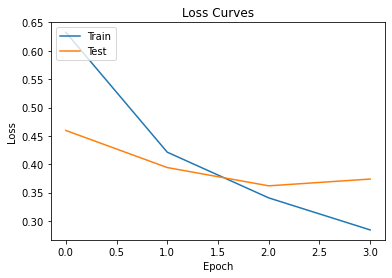

In [26]:
plt.plot(history_xl.history['loss'])
plt.plot(history_xl.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()